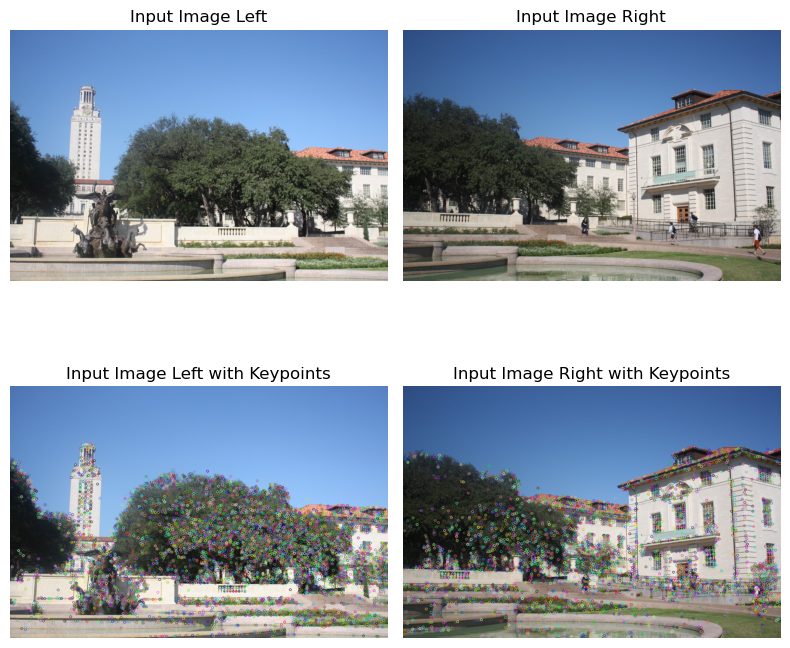

In [1]:
#Şevval Kaplan & Şevval Yardımcı Group Homework-4

import cv2
import numpy as np
import matplotlib.pyplot as plt

class SIFT:
    def __init__(self):
        self.sift = cv2.SIFT_create()

    def detect_and_compute(self, image):
        keypoints, descriptors = self.sift.detectAndCompute(image, None)
        return keypoints, descriptors

#first of all load the imges
imageLeft = cv2.imread('uttower_left.jpg')
imageRight = cv2.imread('uttower_right.jpg')

#then convert images to grayscale
grayLeft = cv2.cvtColor(imageLeft, cv2.COLOR_BGR2GRAY)
grayRight = cv2.cvtColor(imageRight, cv2.COLOR_BGR2GRAY)

sift = SIFT()

#for left image detect and compute keypoints and descriptors 
keypointsLeft, descriptorsLeft = sift.detect_and_compute(grayLeft)

#for right image detect and compute keypoints and descriptors 
keypointsRight, descriptorsRight = sift.detect_and_compute(grayRight)

#draw the keypoints of left and right images
imageLeftWithKeypoints = cv2.drawKeypoints(imageLeft, keypointsLeft, None)
imageRightWithKeypoints = cv2.drawKeypoints(imageRight, keypointsRight, None)

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(imageLeft, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Input Image Left')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(imageRight, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Input Image Right')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(imageLeftWithKeypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Input Image Left with Keypoints')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(imageRightWithKeypoints, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Input Image Right with Keypoints')

plt.tight_layout()
plt.show()



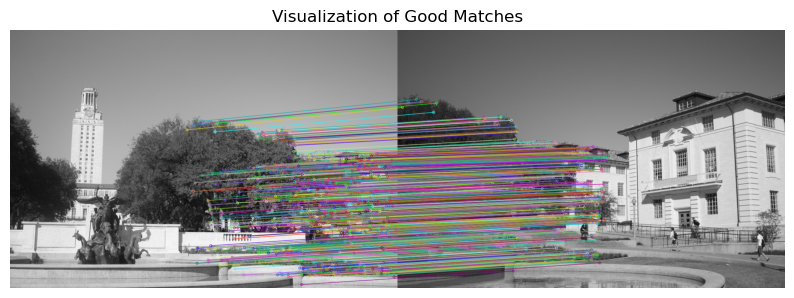

In [7]:
#in this part of the project we use BFMatcher so first initiate BFMatcher
bf = cv2.BFMatcher()

#matching the keypoints of left and right
matches = bf.knnMatch(descriptorsLeft, descriptorsRight, k=2)

#applying ratio test
goodMatches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        goodMatches.append([m])


#visualize the good matches
matchingResult = cv2.drawMatchesKnn(
    grayLeft, keypointsLeft,
    grayRight, keypointsRight,
    goodMatches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(matchingResult, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Visualization of Good Matches')
plt.show()


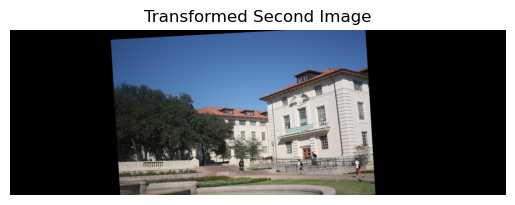

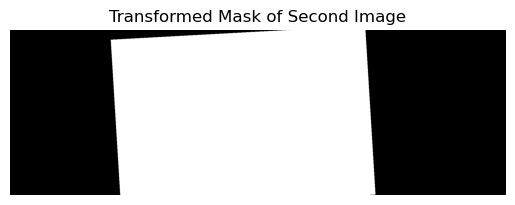

In [9]:
# take the good matches
src_pts = np.float32([keypointsLeft[m[0].queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypointsRight[m[0].trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)


#estimate affine geometric transform
M, _ = cv2.estimateAffine2D(src_pts, dst_pts)

#transform it
transformedImage = cv2.warpAffine(imageRight, M, (imageLeft.shape[1]+imageRight.shape[1], max(imageLeft.shape[0], imageRight.shape[0])), flags=cv2.WARP_INVERSE_MAP)


plt.imshow(cv2.cvtColor(transformedImage, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Transformed Second Image')
plt.show()

#creating mask
mask = np.ones_like(imageRight, dtype=np.uint8) * 255
transformedMask = cv2.warpAffine(mask, M, (imageLeft.shape[1]+imageRight.shape[1], max(imageLeft.shape[0], imageRight.shape[0])), flags=cv2.WARP_INVERSE_MAP)

plt.imshow(cv2.cvtColor(transformedMask, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title('Transformed Mask of Second Image')

plt.show()


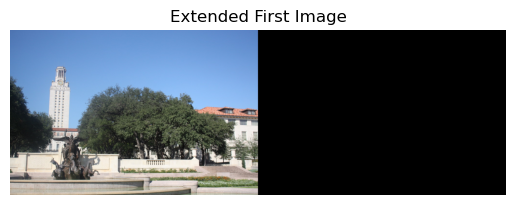

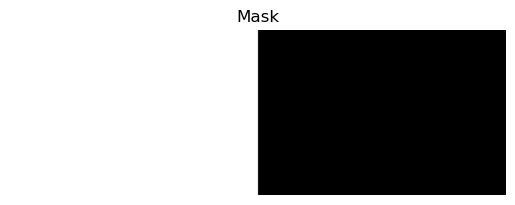

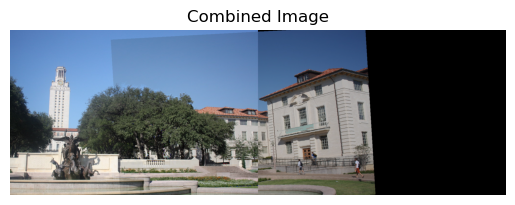

In [42]:
#extend the first image and make mask of it
extendedFirstImage = np.zeros_like(transformedImage)
extendedFirstImage[:imageLeft.shape[0], :imageLeft.shape[1], :] = imageLeft

mask = np.zeros_like(transformedMask, dtype=np.uint8)
mask[:imageLeft.shape[0], :imageLeft.shape[1], :] = 255

normalizedMask = mask / 255.0

#find the overlapped section
overlapRegion = extendedFirstImage[:transformedImage.shape[0], :transformedImage.shape[1], :]

#create a mask for that section
overlapMask = np.zeros_like(overlapRegion, dtype=np.uint8)
overlapMask[:] = 255

#we made the blending
alpha = 1
beta =  (.8 - alpha * normalizedMask)
blendedOverlap = (overlapRegion * alpha) + (transformedImage * beta)


combinedImage = np.copy(extendedFirstImage)
combinedImage[:transformedImage.shape[0], :transformedImage.shape[1], :] = blendedOverlap


rgbExtendedFirstImage = cv2.cvtColor(extendedFirstImage, cv2.COLOR_BGR2RGB)
rgbCombinedImage = cv2.cvtColor(combinedImage.astype(np.uint8), cv2.COLOR_BGR2RGB)


plt.imshow(rgbExtendedFirstImage)
plt.axis("off")
plt.title('Extended First Image')
plt.show()

plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.title('Mask')
plt.show()

plt.imshow(rgbCombinedImage)
plt.axis("off")
plt.title('Combined Image')
plt.show()
